# ALFF analyses of SUVA dataset

Compute and compare the amplitude of low frequency fluctuations

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import os.path, os
import sys
#from nilearn.plotting import plot_anat
from nilearn.signal import clean
from nipype.interfaces.fsl import ImageStats
from nipype.interfaces.fsl.maths import StdImage
sys.path.append("/home/kinany/")
from scipy.signal import filtfilt, cheby2

%matplotlib inline

220414-08:05:50,985 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.7.0


## Data structure
*Note: Inputs images are preprocessed images (native space) NOT filtered*

In [5]:
Root_patients='/media/miplab-nas2/Data/SpinalCord/5_Stroke/SUVA/'
Root_controls='/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/'
#Root='/Volumes/Data/SpinalCord/5_Stroke/SUVA/'
Directories={# Subject info
             #'list_patients':{'001':['T4'],'002':['T3','T4'],'003':['T3','T4'],'004':['T3'],'005':['T2','T3'],'006':['T3'],'007':['T3'],'008':['T2','T3'],'009':['T4'],'010':['T3','T4'],'011':['T2','T4'],'014':['T3','T4'],'016':['T2','T3'],'017':['T3'],'018':['T2','T3'],'019':['T2'],'020':['T4'],'021':['T3'],'022':['T2','T3'],'023':['T3'],'024':['T3'],'025':['T3'],'026':['T2','T3'],'027':['T3'],'028':['T3']},
             #'list_patients':{'005':['T2','T3'],'008':['T2','T3'],'016':['T2','T3'],'018':['T2','T3'],'022':['T2','T3'],'026':['T2','T3']},
             'keep_only_T3':'True',
             'list_patients':{
                '001':{'sess':['T4'],'side':'R','keep_T3':'False'},
                '002':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '003':{'sess':['T3','T4'],'side':'L','keep_T3':'True'},
                '004':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '005':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '006':{'sess':['T3'],'side':'L','keep_T3':'True'},
                '007':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '008':{'sess':['T2','T3'],'side':'L','keep_T3':'True'},
                '009':{'sess':['T4'],'side':'L','keep_T3':'False'},
                '010':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '011':{'sess':['T2','T4'],'side':'R','keep_T3':'False'},
                '014':{'sess':['T3','T4'],'side':'R','keep_T3':'True'},
                '016':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '017':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '018':{'sess':['T2','T3'],'side':'L','keep_T3':'False'},
                '019':{'sess':['T2'],'side':'R','keep_T3':'False'},
                '020':{'sess':['T4'],'side':'L','keep_T3':'False'},
                '021':{'sess':['T3'],'side':'L','keep_T3':'True'},
                '022':{'sess':['T2','T3'],'side':'R','keep_T3':'True'},
                '023':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '024':{'sess':['T3'],'side':'R','keep_T3':'False'},
                '025':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '026':{'sess':['T2','T3'],'side':'L','keep_T3':'True'},
                '027':{'sess':['T3'],'side':'L','keep_T3':'False'},
                '028':{'sess':['T3'],'side':'R','keep_T3':'True'},
                '031':{'sess':['T3'],'side':'L','keep_T3':'True'}},
             'list_controls':{'RS_AT':['RS_Moco_SCT'],'RS_EP':['RS_Moco_SCT'],'RS_FB':['RS_Moco_SCT'],'RS_GB':['RS_Moco_SCT'],'RS_GP':['RS_Moco_SCT'],'RS_LJ':['RS_Moco_SCT'],'RS_MD':['RS_Moco_SCT'],'RS_MP':['RS_Moco_SCT'],'RS_NG':['RS_Moco_SCT'],'RS_NK':['RS_Moco_SCT'],'RS_RL':['RS_Moco_SCT'],'RS_SA':['RS_Moco_SCT'],'RS_SL':['RS_Moco_SCT'],'RS_SW':['RS_Moco_SCT'],'RS_VG':['RS_Moco_SCT'],'RS_VS':['RS_Moco_SCT'],'RS_YF':['RS_Moco_SCT'],'RS_AO':['RS_Moco_SCT'],'RS_AS':['RS_Moco_SCT']},
             'SubRoot_patients':'SUVA-TIMES-',
              # Functional info
             'FuncDir_patients':'/Functional/',
             'FuncDir_controls':'/Functional_SCT/',
             'FuncName_patients':'fmri_moco_denoised',
             'FuncName_controls':'residuals240vol_native_noWM',
             'MaskName_patients':'fmri_mask_sc',
             'MaskName_controls':'mask_sc',
             'MaskDir':'Segmentation/',
             # Lesion info
             'LesionDir': Root_patients + 'LesionAnalysis/',
             'acute_only': True, # True if we take only acute part of the lesions (for the subjects with old lesions)
             # ALFF info
             'bp_range': [0.01,0.13],
             'overwrite_bp': False, # Set True to overwrite previous band-pass filtering
             'overwrite_alff': False, # Set True to overwrite previous ALFF computation
             'overwrite_flipped': False, # Set True to overwrite previous L-R flipping 
             'overwrite_df': False, # Set True to overwrite dataframe containing ALFF values
             # ROI info
             'RoiDir': '/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/PAM50_t2_common/masks/mask_',
             'roi_names':['C5toC7_short_gm_RV','C5toC7_short_gm_LV','C5toC7_short_gm_RD','C5toC7_short_gm_LD']
             } 

## ALFF function

In [3]:
def compute_alff(data_path,func_file,mask_file,Wn):
    ''' Computes amplitude of low frequency fluctuations (ALFF) for each voxel.
    
        Parameter
        ----------
        data_path : path containing the data
        func_file : name of the 4D nifti file containing the time series (native space)
        mask_file : name of the 3D nifti file containing the spinal cord mask (native space)
        Wn : range of frequencies to keep [f1 f2]

        Return
        -------
        alff_img : 3D array containing the sum of the amplitudes in the low frequency band (ALFF)
        alff_Z_img : 3D array containing the Z-scored ALFF 
    '''
    
    print('Input -> ' + func_file)
    print('STEP 1: Bandpass filter') 
    
#     # Test
#     data_img = nib.load(data_path+func_file+ '.nii.gz')
#     data_bp = clean(signals=data_img.get_fdata(), t_r=2.5, high_pass=bp1, low_pass=bp2, detrend=False, standardize=False, standardize_confounds=False)
#     print(f'Data shape {data_bp.shape}')
#     data_bp_img = nib.Nifti1Image(data_bp, data_img.affine, data_img.header)
#     nib.save(data_bp_img,data_path+func_file+ '_bp_clean.nii.gz')
    
#     # end test
    if not os.path.isfile(data_path+func_file + '_bp.nii.gz') or Directories['overwrite_bp']:
        # Using the same filter as Barry 2014 (gave nicest filtering when checking with Ila)
        img = nib.load(data_path+func_file+ '.nii.gz')
        data = img.get_fdata()
        filtered_data = temporal_filter2(data,Wn)
        data_bp_img = nib.Nifti1Image(filtered_data, img.affine, img.header)
        nib.save(data_bp_img,data_path+func_file + '_bp.nii.gz')
    
    print('STEP 2: Standard deviation')
    if not os.path.isfile(data_path+func_file + '_alff.nii.gz') or Directories['overwrite_alff']:
        std = StdImage(in_file=data_path+func_file + '_bp.nii.gz', out_file=data_path+func_file + '_alff.nii.gz', output_type='NIFTI_GZ')
        std.run()
    
    print('STEP 3: Z-score')
    if not os.path.isfile(data_path+func_file + '_alff_Z.nii.gz') or Directories['overwrite_alff']:
        # Compute std and mean in mask
        stats_mean = ImageStats(in_file=data_path+func_file + '_alff.nii.gz', mask_file=data_path+mask_file+'.nii.gz',op_string= '-m')
        mean = stats_mean.run().outputs.out_stat
        stats_std = ImageStats(in_file=data_path+func_file + '_alff.nii.gz', mask_file=data_path+mask_file+'.nii.gz',op_string= '-s')
        std = stats_std.run().outputs.out_stat
        # Compute z-score ALFF
        run_string = 'fslmaths ' + data_path+func_file + '_alff.nii.gz -sub ' + str(mean) + ' -div ' + str(std) + ' ' + data_path + func_file + '_alff_Z.nii.gz'
        os.system(run_string)
    
    print('STEP 4: Normalization')
    if not os.path.isfile(data_path+func_file + '_alff_Z_pam50.nii.gz') or Directories['overwrite_alff']:
        run_string = '/home/kinany/sct_3.2.7/bin/sct_apply_transfo -i ' + data_path + func_file + '_alff_Z.nii.gz -d /media/miplab-nas3/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/PAM50_t2_common/template/PAM50_t2.nii.gz -w ' + data_path + 'Normalization/warp_fmri2template.nii.gz -x linear -o ' + data_path+func_file + '_alff_Z_pam50.nii.gz'
        os.system(run_string)  
        
def temporal_filter2(raw_signal, Wn):
    ''' Computes filtered version of a timeseries (voxelwise) 
        Note: same filter as Barry 2014
    
        Parameter
        ----------
        raw_signal : unfiltered signal (array)
        Wn : range of frequencies to keep [f1 f2]
        
        Return
        -------
        filt_signal : filtered signal (array)
    '''    
    b,a = cheby2(4, 30, Wn, 'bandpass', fs=1./2.5)
    filt_signal = filtfilt(b,a,raw_signal)
    return filt_signal

### ALFF

### Compute ALFF maps

### _1. Patients_

In [4]:
for sub in Directories['list_patients']: # Loop through all subjects
    for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject        
        sub_id = Directories['SubRoot_patients'] + sub + '-' + session + '-'
        sub_data_path = Root_patients + Directories['SubRoot_patients'] + sub + '/' + session + Directories['FuncDir_patients']
        sub_func_file = sub_id + Directories['FuncName_patients'] 
        compute_alff(data_path = sub_data_path, func_file = sub_func_file, mask_file = Directories['MaskDir'] + sub_id + Directories['MaskName_patients'],Wn = Directories['bp_range'])
        
        # Flip brain to have consistently the lesions on the right side
        if (not os.path.isfile(sub_data_path + sub_func_file + '_alff_Z_pam50_flipped.nii.gz') or Directories['overwrite_flipped']) and Directories['list_patients'][sub]['side'] == 'L':
            img_toflip = nib.load(sub_data_path + sub_func_file + '_alff_Z_pam50.nii.gz')
            data_toflip = img_toflip.get_fdata()
            data_flipped = data_toflip[::-1]
            img_flipped = nib.Nifti1Image(data_flipped, img_toflip.affine, img_toflip.header)
            nib.save(img_flipped,sub_data_path + sub_func_file + '_alff_Z_pam50_flipped.nii.gz')

Input -> SUVA-TIMES-001-T4-fmri_moco_denoised
STEP 1: Bandpass filter


KeyboardInterrupt: 

### _2. Controls_

In [ ]:
for sub in Directories['list_controls']: # Loop through all subjects
    for session in Directories['list_controls'][sub]: # Loop through sessions for a particular subject        
        compute_alff(data_path = Root_controls + sub + Directories['FuncDir_controls'] + session + '/',
                     func_file = Directories['FuncName_controls'], mask_file = Directories['MaskDir'] + Directories['MaskName_controls'],
                     Wn = Directories['bp_range'])

### Compute mean ALFF in masks

In [6]:
subs = []
sessions = []
rois = []
alffs = []

if not os.path.isfile('alff_df.pkl') or Directories['overwrite_df']:
    for roi in Directories['roi_names']:
        for sub in Directories['list_patients']: # Loop through all subjects
            for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject
                # Either we keep only T3, or we consider all subjects
                if (Directories['keep_only_T3'] == 'True' and Directories['list_patients'][sub]['keep_T3'] == 'True' and session == 'T3') or Directories['keep_only_T3'] == 'False':
                    subs.append(sub)
                    sessions.append(session)
                    rois.append(roi)
                    if Directories['list_patients'][sub]['side'] == 'R':
                        stats = ImageStats(in_file=Root_patients + Directories['SubRoot_patients'] + sub + '/' + session + Directories['FuncDir_patients'] + Directories['SubRoot_patients'] + sub + '-' + session + "-" + Directories['FuncName_patients'] + '_alff_Z_pam50.nii.gz', mask_file=Directories['RoiDir'] + roi + '.nii.gz',op_string= '-k %s -M')
                    else:
                        stats = ImageStats(in_file=Root_patients + Directories['SubRoot_patients'] + sub + '/' + session + Directories['FuncDir_patients'] + Directories['SubRoot_patients'] + sub + '-' + session + "-" + Directories['FuncName_patients'] + '_alff_Z_pam50_flipped.nii.gz', mask_file=Directories['RoiDir'] + roi + '.nii.gz',op_string= '-k %s -M')

                    alffs.append(stats.run().outputs.out_stat)
        for sub in Directories['list_controls']: # Loop through all subjects
            for session in Directories['list_controls'][sub]: # Loop through sessions for a particular subject
                subs.append(sub)
                sessions.append(session)
                rois.append(roi)
                stats = ImageStats(in_file=Root_controls + sub + Directories['FuncDir_controls'] + session + '/' + Directories['FuncName_controls'] + '_alff_Z_pam50.nii.gz', mask_file=Directories['RoiDir'] + roi + '.nii.gz',op_string= '-k %s -M')
                alffs.append(stats.run().outputs.out_stat)

    colnames = ["sub","sess","roi","alff"]
    alff_df = pd.DataFrame(list(zip(subs,sessions,rois,alffs)),columns=colnames)
    alff_df.to_pickle('alff_df.pkl')  # Save dataframe
else:
    alff_df = pd.read_pickle('alff_df.pkl')


### Plot mean ALFF (over subjects) per session and per roi

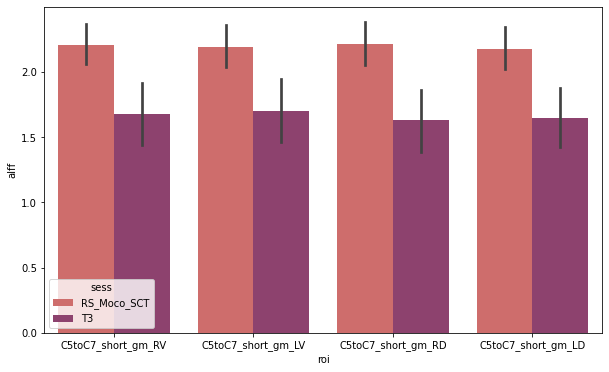

In [7]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="roi",y="alff",hue="sess",data=alff_df,hue_order=['RS_Moco_SCT','T3'],palette='flare')

### Compute lesion CST load

In [9]:
subs = []
sessions = []
weighted_load_L = []
weighted_load_R = []
lesion_vol = []

# Function for CST load computation
def compute_weighted_load(lesion,side):
    ''' Computes CST load (weighted, using binarized atlas), see https://onlinelibrary.wiley.com/doi/10.1002/ana.24510
    
        Parameter
        ----------
        lesion : 3D array containing the mask of the overlap
        side: left (0) or right (1) hemicord

        Return
        -------
        load : weighted load
    '''
    # ATLAS
    if side == 0:
        template = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_L_resized_bin_thr70.nii.gz')
    elif side == 1:
        template = nib.load(Directories['LesionDir'] + 'Atlas/FSL_CST_R_resized_bin_thr70.nii.gz')
    template_np = template.get_fdata()   
    sum_slice = template_np.sum(axis=(0,1)) # Sum of voxels per slice (atlas)
    with np.errstate(all='ignore'):
        ratio_slice = sum_slice.max() / sum_slice # Maximum number of voxels
        
    # LESION
    sum_slice_lesion = lesion.sum(axis=(0,1)) # Sum of voxel per slice (lesion)
    with np.errstate(all='ignore'):
        weighted_overlap = np.nansum(sum_slice_lesion * ratio_slice)
    return weighted_overlap

# Compute load for each subject / session
for sub in Directories['list_patients']: # Loop through all subjects
    for session in Directories['list_patients'][sub]['sess']: # Loop through sessions for a particular subject
        if (Directories['keep_only_T3'] == 'True' and Directories['list_patients'][sub]['keep_T3'] == 'True' and session == 'T3') or Directories['keep_only_T3'] == 'False':
            subs.append(sub)
            sessions.append(session)
            tmp_load = np.zeros((2,1))
            for sideix,side in enumerate(['L','R']):
                if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz'):
                    lesion_overlap = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz')
                else:
                    lesion_overlap = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-overlap_FSL_CST_' + side + '.nii.gz')
                lesion_overlap_np = lesion_overlap.get_fdata()
                if side == 'L':
                    weighted_load_L.append(compute_weighted_load(lesion_overlap_np,sideix))
                elif side =='R':
                    weighted_load_R.append(compute_weighted_load(lesion_overlap_np,sideix))

            # Add also total volume of lesion
            if Directories['acute_only']==True and os.path.isfile(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-acute_only-overlap_FSL_CST_' + side + '.nii.gz'):
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-lesion_acute_only.nii')
            else:
                lesion = nib.load(Directories['LesionDir'] + 'Lesions/' + Directories['SubRoot_patients'] + sub + '-' + session + '-lesion.nii')
            lesion_np = lesion.get_fdata()
            lesion_vol.append(np.sum(lesion_np))   
            del tmp_load
                
colnames = ["sub","sess","CST_L", "CST_R", "vol"]
lesions_df = pd.DataFrame(list(zip(subs,sessions,weighted_load_L,weighted_load_R,lesion_vol)),columns=colnames)


### Evaluate link between CST load and ALFF

In [10]:
lesions_df

,sub,sess,CST_L,CST_R,vol
0,002,T3,0.000000,37.492105,153.0
1,003,T3,378.224805,0.000000,583.0
2,005,T3,0.000000,0.000000,7336.0
3,006,T3,183.473253,0.000000,821.0
4,007,T3,0.000000,0.000000,1449.0
5,008,T3,268.873440,0.000000,305.0
6,010,T3,0.000000,0.000000,621.0
7,014,T3,0.000000,0.000000,3645.0
8,016,T3,0.000000,8.970100,15344.0
9,021,T3,0.000000,0.000000,3020.0


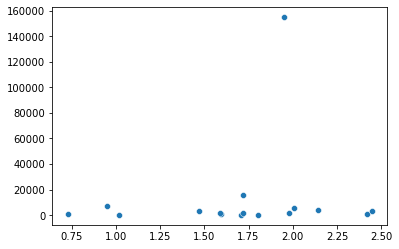

In [12]:
fig = sns.scatterplot(x=(alff_df.loc[(alff_df['sess']=='T3') & (alff_df['roi']=='C5toC7_short_gm_LV'),'alff'].values),y=lesions_df.loc[lesions_df['sess']=='T3','vol'].values)


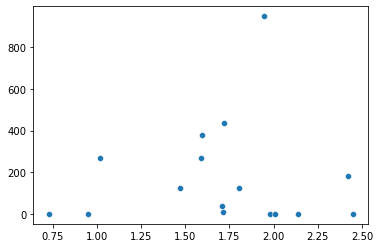

In [14]:
fig = sns.scatterplot(x=(alff_df.loc[(alff_df['sess']=='T3') & (alff_df['roi']=='C5toC7_short_gm_LV'),'alff'].values),y=(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values+lesions_df.loc[lesions_df['sess']=='T3','CST_R']).values)



In [15]:
fig = sns.scatterplot(x=(alff_df.loc[(alff_df['sess']=='T3') & (alff_df['roi']=='C5toC7_short_gm_LV'),'alff'].values),y=(np.sum(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values+lesions_df.loc[lesions_df['sess']=='T3','CST_R'].values)
                      

SyntaxError: unexpected EOF while parsing (798851414.py, line 2)

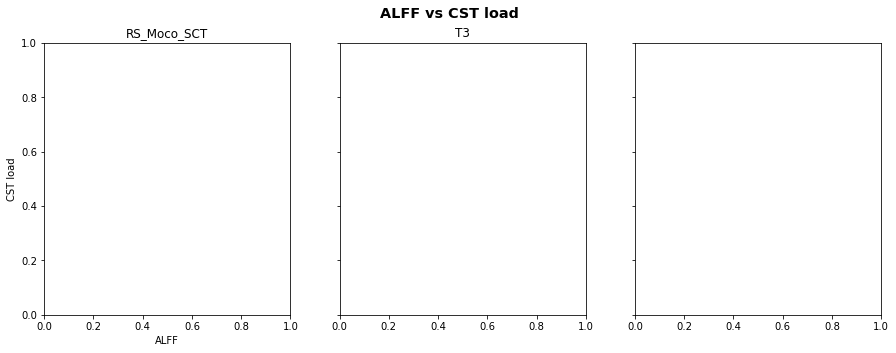

In [16]:
# Find which sessions to include
sessnames = sorted(alff_df.loc[:,"sess"].unique())
# Note, to access specific values -> alff_df[(alff_df['sess']=='T2') & (alff_df['sub']=='005')]
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)
fig.suptitle('ALFF vs CST load',fontsize='x-large',weight="bold");
for sessix,sess in enumerate(sessnames):
    sns.scatterplot(x=alff_df.loc[(alff_df['sess']==sess) & (alff_df['roi']=='C5toC7_short_LD'),'alff'],y=np.sum(lesions_df.loc[lesions_df['sess']=='T3','CST_L'].values+lesions_df.loc[lesions_df['sess']=='T3','CST_R'].values),ax=axes[sessix])
    axes[sessix].set_title(sess)
plt.setp(axes[0], xlabel='ALFF');
plt.setp(axes[0], ylabel='CST load');

Test

In [11]:
from nilearn.maskers import NiftiMasker
from nilearn.masking import apply_mask

In [6]:
masker = NiftiMasker(mask_img='/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/PAM50_t2_common_light/masks/GM_bin_RV_C5toC7.nii.gz')
time_series = masker.fit_transform('/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/RS_AT/Functional_SCT/RS_Moco_SCT/residuals240vol_native_noWM_bp_pam50_caro.nii.gz')

In [14]:
time_series.shape

(360, 906)

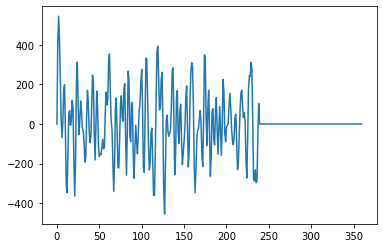

In [22]:
mean_ts = np.mean(time_series,axis=1)
plt.plot(mean_ts)

In [12]:
ts = apply_mask('/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/RS_AT/Functional_SCT/RS_Moco_SCT/residuals240vol_native_noWM_bp_pam50_caro.nii.gz','/media/miplab-nas2/Data/SpinalCord/3_RestingState/LongRecordings/Cervical/PAM50_t2_common_light/masks/GM_bin_RV_C5toC7.nii.gz')

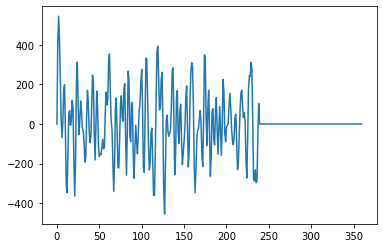

In [27]:
mean_ts2 = np.mean(ts,axis=1)
plt.plot(mean_ts2);

## Useful 

In [ ]:
# # Two ways to store images
# # OPTION 1: list
# list_img = []
# for sub in Directories['list_patients']: # Loop through all subjects
#     for session in Directories['list_patients'][sub]: # Loop through sessions for a particular subject        
#         list_img.append(nib.load(Root + Directories['SubRoot_patients'] + sub + '/' + session + Directories['FuncDir_patients'] + Directories['SubRoot_patients'] + sub + '-' + session + '-' + Directories['FuncName_patients']).get_fdata())

# # OPTION 2: dictionary    
# subs_dict = {sub: [] for sub in Directories['list_patients']} # create empty dictionary
# for sub in Directories['list_patients']: # Loop through all subjects
#     for session in Directories['list_patients'][sub]: # Loop through sessions for a particular subject        
#         subs_dict[sub].append(nib.load(Root + Directories['SubRoot_patients'] + sub + '/' + session + Directories['FuncDir_patients'] + Directories['SubRoot_patients'] + sub + '-' + session + '-' + Directories['FuncName_patients']).get_fdata())

# # Can access list with subs_dict['001'][1]